In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [50]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import pickle

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from ...custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
# from custom_classes_defs.fnet_like import *
from custom_classes_defs.fnet import *


RND_STATE = 247
BATCH_SIZE = 512
EPOCHS = 100
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

In [52]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()
img_url = '../thebe_new/seismic'
target_url = '../thebe_new/fault'
seis = Thebe(img_url, target_url)

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------
...elapsed time: ___ 0.00 minutes___


In [53]:
start = time.time()
save_path = './models/Thebe/'
unet_path = 'models/Thebe/unet'
fnet_path = 'models/Thebe/fnet'

with open(join(save_path, 'images.npy'), "rb") as fp:
    images = np.load(fp)

with open(join(save_path, 'labels.npy'), "rb") as fp:
    labels = np.load(fp)

with open(join(save_path, 'index.npy'), "rb") as fp:
    index = np.load(fp)

seis.image_size = images.shape[1:-1]

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

...elapsed time: ___ 0.00 minutes___


In [54]:
# Model configurations
conf = model_config(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path=save_path,
    img_shape=seis.img_size,
    target_size=seis.img_size,
    threshold=seis.threshold,
    pos_label=seis.pos_label
)

assert not(conf.new_training_session)

conf.info()

             NUM_GPU: 0
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: None
new_training_session: False
           pos_label: 1
resume_training_session: 0
           save_path: ./models/Thebe/
           test_size: None
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
   training_duration: None
     validation_size: None


### Build and load model weights

In [55]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build models', '-'*55))

m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
model_unet = m_obj.build_model()
model_unet.load_weights(glob(unet_path+'/*.h5')[0])


m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
model_fnet = m_obj.build_model()
model_fnet.load_weights(glob(fnet_path+'/*.h5')[0])


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
print(f"Total number of parameters for {model_unet.name}: {model_unet.count_params():,}")
print(f"Total number of parameters for {model_fnet.name}: {model_fnet.count_params():,}")





	Build models
-------------------------------------------------------
Total number of parameters for U-NET: 1,845,409
Total number of parameters for F-NET: 6,824,641


In [113]:
layer_outputs = []
layer_names = []
for layer in model_unet.layers:
    if layer.name.__contains__('up_sampling'):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

up_sampling2d_69
up_sampling2d_70
up_sampling2d_71


In [114]:
activation_model = keras.Model(inputs=model_unet.inputs, outputs=layer_outputs)
#activation_model.summary()
activations = activation_model.predict(images)

1/1 [==============================] - 1s 625ms/step


In [115]:
num_layers = len(layer_names)
for i in range(num_layers):
    print(f"layer {layer_names[i]}: {activations[i].shape}")

layer up_sampling2d_69: (8, 24, 24, 128)
layer up_sampling2d_70: (8, 48, 48, 64)
layer up_sampling2d_71: (8, 96, 96, 32)


In [123]:
num_images =  len(images)
def plot_images():
    fig, axs = plt.subplots(nrows=1, ncols=8)
    fig.set_figwidth(15)
    for i in range(num_images):
        axs[i].set_axis_off()
        axs[i].imshow(images[i,:,:], cmap='seismic')
    fig.tight_layout(pad=0.5)
    plt.show()

def plot_labels():
    fig, axs = plt.subplots(nrows=1, ncols=8)
    fig.set_figwidth(15)
    for i in range(num_images):
        axs[i].set_axis_off()
        axs[i].imshow(labels[i,:,:], cmap='seismic')
    fig.tight_layout(pad=0.5)
    plt.show()

def plot_activations(activations, num=0):
    fig, axs = plt.subplots(nrows=1, ncols=8)
    fig.set_figwidth(15)
    for i in range(num_images):
        axs[i].set_axis_off()
        axs[i].imshow(activations[num][i,:,:,0], cmap='seismic')
    fig.tight_layout(pad=0.5)
    plt.show()

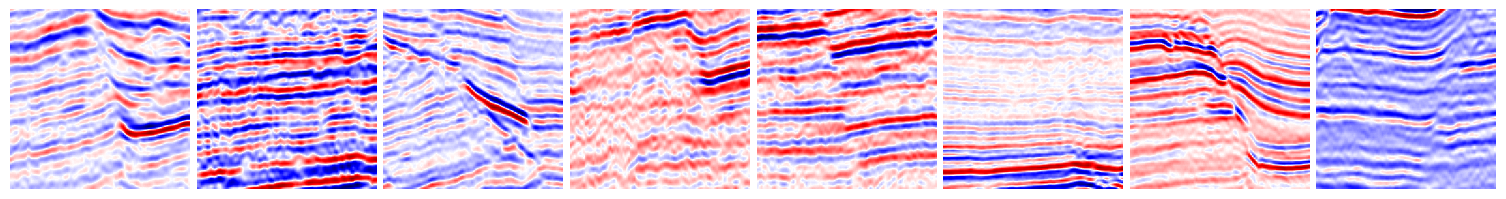

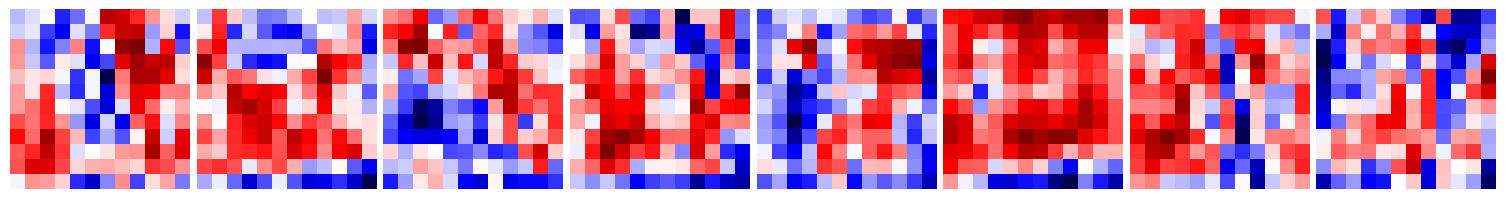

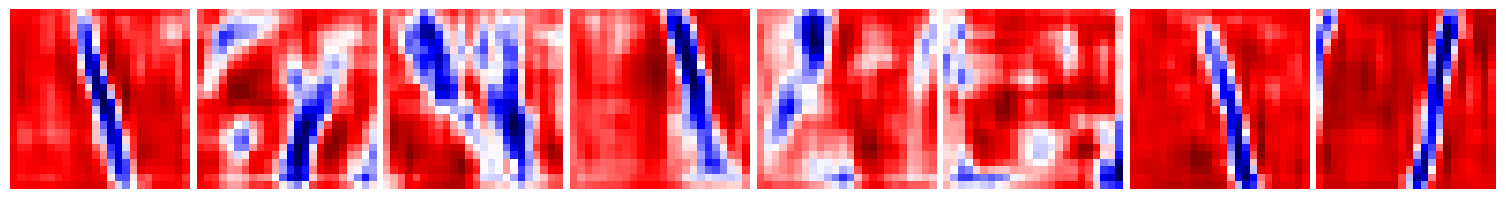

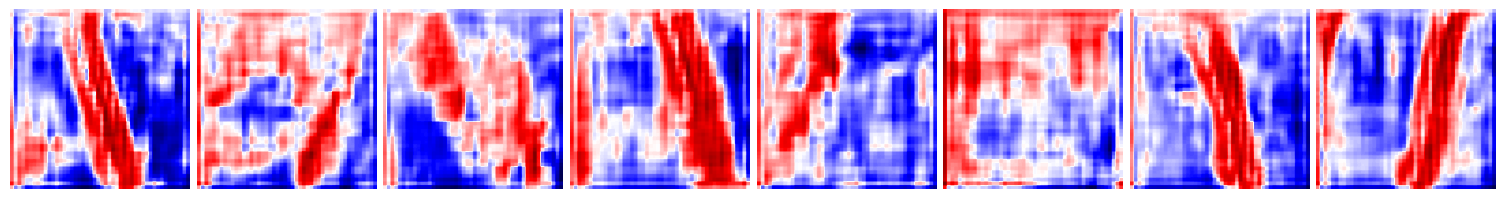

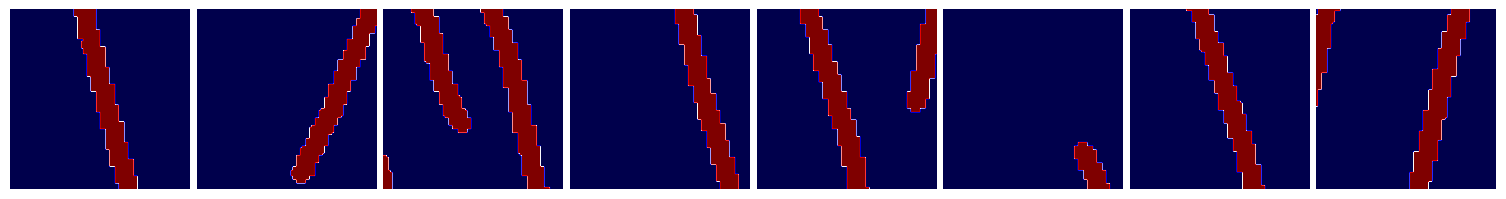

In [124]:
plot_images()
for n in range(num_layers):
    plot_activations(activations, n)
plot_labels()

In [133]:
# model_fnet.summary()

In [137]:
layer_outputs = []
layer_names = []
for layer in model_fnet.layers:
    if layer.name.__contains__('up_sampling2d_8'):
        code = int(layer.name[-2:])
        if code >= 85 and code % 2 == 1:
            print(layer.name)
            layer_outputs.append(layer.output)
            layer_names.append(layer.name)

up_sampling2d_85
up_sampling2d_87
up_sampling2d_89


In [138]:
activation_model = keras.Model(inputs=model_fnet.inputs, outputs=layer_outputs)
#activation_model.summary()
activations = activation_model.predict(images)

1/1 [==============================] - 3s 3s/step


In [139]:
num_layers = len(layer_names)
for i in range(num_layers):
    print(f"layer {layer_names[i]}: {activations[i].shape}")

layer up_sampling2d_85: (8, 24, 24, 256)
layer up_sampling2d_87: (8, 48, 48, 128)
layer up_sampling2d_89: (8, 96, 96, 64)


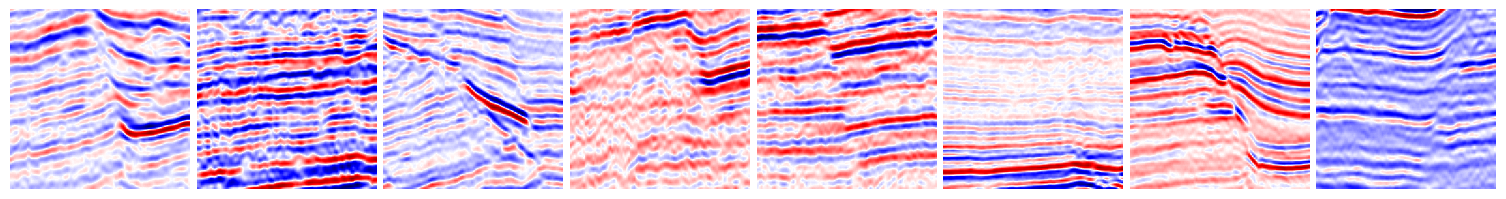

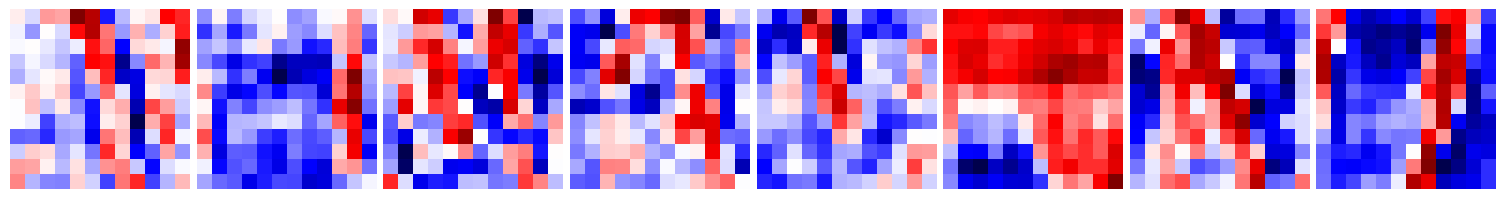

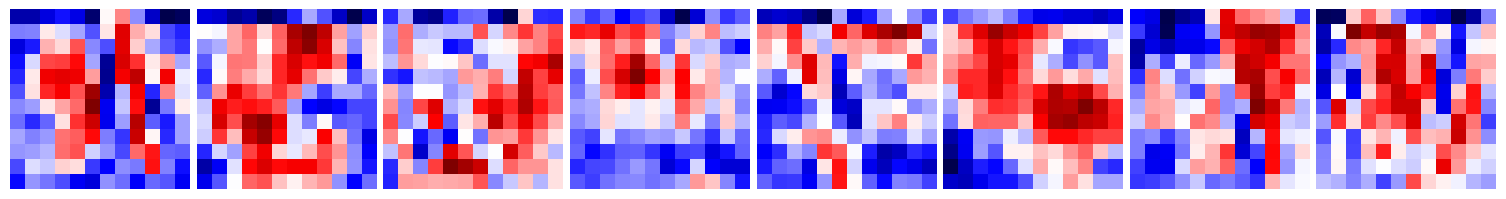

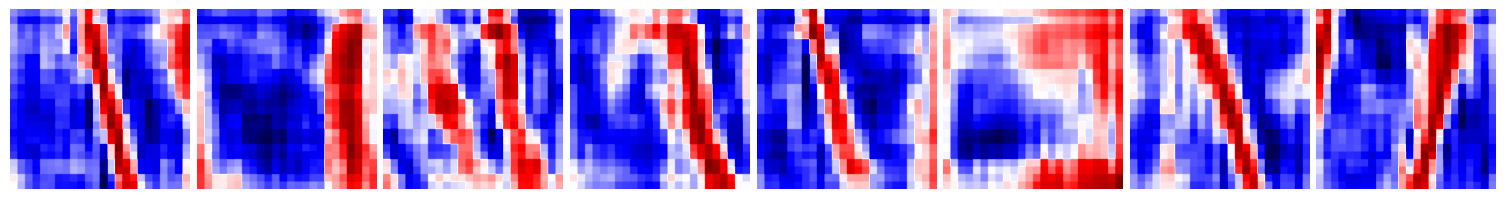

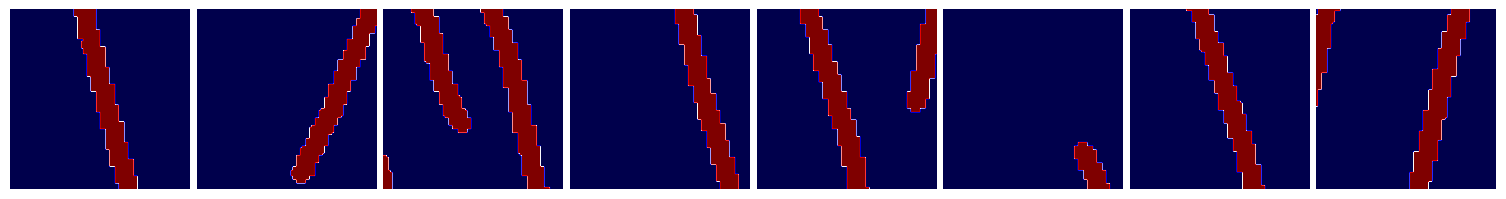

In [140]:
plot_images()
for n in range(num_layers):
    plot_activations(activations, n)
plot_labels()